In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer
from scalar_features import ScalarFeaturizer
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPE_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin1_twin_xminPE_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [12]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)

In [13]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')

In [14]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 20098


## Check out halos with diff most-massive compared to twin

To start let's look at ALL dark subhalos, not just those that are the most massive in their group:

In [70]:
fn_match_dark_to_full = f'../data/subhalo_matching_dicts/subhalo_dark_to_full_dict_{sim_name}.npy'
fn_match_full_to_dark = f'../data/subhalo_matching_dicts/subhalo_full_to_dark_dict_{sim_name}.npy'

subhalo_dark_to_full_dict = np.load(fn_match_dark_to_full, allow_pickle=True).item()
subhalo_full_to_dark_dict = np.load(fn_match_full_to_dark, allow_pickle=True).item()
print(len(subhalo_dark_to_full_dict))

idxs_subtwins = []
idxs_submassives = []

num_star_particles_min = 1
halo_mass_min = 10**10.8
halo_mass_min /= mass_multiplier
halo_mass_max = None
halo_mass_difference_factor = 3.0

for idx_subhalo_dark in subhalo_dark_to_full_dict:
    idx_subtwin_hydro = subhalo_dark_to_full_dict[idx_subhalo_dark]
    
    # This is that hydro subhalo's parent halo in the hydro sim
    idx_halo_hydro = sim_reader.subhalos_hydro['SubhaloGrNr'][idx_subtwin_hydro]

    # This is the largest hydro subhalo of that hydro halo
    idx_subhalomassive_hydro = sim_reader.halos_hydro['GroupFirstSub'][idx_halo_hydro]
    
    # This is the dark subhalo's parent halo in the dark sim

    idx_halo_dark = sim_reader.subhalos_dark['SubhaloGrNr'][idx_subhalo_dark]

#     num_star_parts_subtwin = sim_reader.subhalos_hydro['SubhaloLenType'][:,sim_reader.ipart_star][idx_subtwin_hydro]
#     num_star_parts_submassive = sim_reader.subhalos_hydro['SubhaloLenType'][:,sim_reader.ipart_star][idx_subhalomassive_hydro]
#     zero_stars_subtwin = num_star_parts_subtwin < 1
#     zero_stars_submassive = num_star_parts_submassive < 1
#     if zero_stars_subtwin != zero_stars_submassive:
#         print(num_star_parts_subtwin, num_star_parts_submassive)

    # if number of stars below a minimum, exclude
    # here selecting on twin, bc need to choose
    if num_star_particles_min is not None and sim_reader.subhalos_hydro['SubhaloLenType'][:,sim_reader.ipart_star][idx_subhalomassive_hydro] < num_star_particles_min: 
    #if num_star_particles_min is not None and sim_reader.subhalos_hydro['SubhaloLenType'][:,sim_reader.ipart_star][idx_subtwin_hydro] < num_star_particles_min: 
        continue

    # if halo is below a minimum mass, exclude
    if halo_mass_min is not None and sim_reader.halos_dark['GroupMass'][idx_halo_dark] < halo_mass_min: 
        continue

    # if halo is above a maximum mass, exclude
    if halo_mass_max is not None and sim_reader.halos_dark['GroupMass'][idx_halo_dark] > halo_mass_max: 
        continue

    # if dark halo and hydro halo masses differ significantly, likely a mismatch; exclude
    if halo_mass_difference_factor is not None and sim_reader.halos_hydro['GroupMass'][idx_halo_hydro] > halo_mass_difference_factor*sim_reader.halos_dark['GroupMass'][idx_halo_dark]: 
        continue
                
    idxs_subtwins.append(idx_subtwin_hydro)    
    idxs_submassives.append(idx_subhalomassive_hydro)
    
idxs_subtwins = np.array(idxs_subtwins)
idxs_submassives = np.array(idxs_submassives)
print(len(idxs_subtwins), len(idxs_submassives))

3593484
343608 343608


In [51]:
n_pairs = len(idxs_subtwins)
i_equal = idxs_subtwins == idxs_submassives
print(len(idxs_subtwins), len(idxs_submassives))
n_same = len(np.where(i_equal==True)[0])
n_diff = len(np.where(i_equal==False)[0])
print(f"{n_diff}/{n_pairs}={n_diff/n_pairs:.3f} have different twin & most massive subhalo")

97615 97615
67365/97615=0.690 have different twin & most massive subhalo


In [57]:
subtwin_stellar_masses = np.array([sim_reader.subhalos_hydro['SubhaloMassType'][:,sim_reader.ipart_star][idx] for idx in idxs_subtwins])
submassive_stellar_masses = np.array([sim_reader.subhalos_hydro['SubhaloMassType'][:,sim_reader.ipart_star][idx] for idx in idxs_submassives])

In [65]:
plt.scatter(subtwin_stellar_masses*mass_multiplier, submassive_stellar_masses*mass_multiplier, 
            color='k', s=6, alpha=0.15)
plt.xlabel('m_stellar of twin hydro subhalo')
plt.ylabel('m_stellar of most massive \nsubhalo in twin hydro halo')
plt.loglog()

[]

Why are there some "most massive" halos smaller than the twin?? 

_GroupFirstSub: Index into the Subhalo table of the first/primary/most massive Subfind group within this FoF group. Note: This value is signed (or should be interpreted as signed)! In this case, a value of -1 indicates that this FoF group has no subhalos._


Now let's look at just our sample where we've taken the most massive dark subhalos only:

In [107]:
halo_tag_twin = '_nstarpartmin1_twin'
fn_dark_halo_arr_twin = f'{halo_dir}/halos_{sim_name}{halo_tag_twin}.npy'
sim_reader_twin = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader_twin.load_dark_halo_arr(fn_dark_halo_arr_twin)
sim_reader_twin.read_simulations()

In [108]:
halo_tag_massive = '_nstarpartmin1'
fn_dark_halo_arr_massive = f'{halo_dir}/halos_{sim_name}{halo_tag_massive}.npy'
sim_reader_massive = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader_massive.load_dark_halo_arr(fn_dark_halo_arr_massive)
sim_reader_massive.read_simulations()

In [98]:
idxs_twin = np.array([halo.idx_subhalo_hydro for halo in sim_reader_twin.dark_halo_arr])
idxs_massive = np.array([halo.idx_subhalo_hydro for halo in sim_reader_massive.dark_halo_arr])

In [99]:
idxs_twin == idxs_massive

array([ True,  True,  True, ...,  True,  True,  True])

In [101]:
n_pairs = len(idxs_twin)
i_equal = idxs_twin == idxs_massive
print(len(idxs_twin), len(idxs_massive))
n_same = len(np.where(i_equal==True)[0])
n_diff = len(np.where(i_equal==False)[0])
print(f"{n_diff}/{n_pairs}={n_diff/n_pairs:.4f} have different twin & most massive subhalo")

20098 20098
145/20098=0.0072 have different twin & most massive subhalo


In [103]:
subtwin_stellar_masses = np.array([sim_reader_twin.subhalos_hydro['SubhaloMassType'][:,sim_reader_twin.ipart_star][idx] for idx in idxs_twin])
submassive_stellar_masses = np.array([sim_reader_massive.subhalos_hydro['SubhaloMassType'][:,sim_reader_massive.ipart_star][idx] for idx in idxs_massive])

In [106]:
n_twin_greater = len(np.where(subtwin_stellar_masses > submassive_stellar_masses)[0])
print(n_twin_greater)

66


In [104]:
plt.scatter(subtwin_stellar_masses*mass_multiplier, submassive_stellar_masses*mass_multiplier, 
            color='k', s=6, alpha=0.15)
plt.xlabel('m_stellar of twin hydro subhalo')
plt.ylabel('m_stellar of most massive \nsubhalo in twin hydro halo')
plt.loglog()

[]

Still some with twin larger than most massive! Oh is it because this is based on total mass?

In [109]:
subtwin_masses = np.array([sim_reader_twin.subhalos_hydro['SubhaloMass'][idx] for idx in idxs_twin])
submassive_masses = np.array([sim_reader_massive.subhalos_hydro['SubhaloMass'][idx] for idx in idxs_massive])

In [110]:
plt.scatter(subtwin_masses*mass_multiplier, submassive_masses*mass_multiplier, 
            color='k', s=6, alpha=0.15)
plt.xlabel('m_total of twin hydro subhalo')
plt.ylabel('m_total of most massive \nsubhalo in twin hydro halo')
plt.loglog()

[]

Ah dope, understood

## Set up general scalar featurizer

In [116]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_rebinned)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms,
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

## Uncertainties & powerlaw

In [112]:
uncertainties_genel2019 = utils.get_uncertainties_genel2019(log_m_stellar+log_mass_shift, sim_name=sim_name)

In [113]:
y_val_current_powerlaw_fit, initial_guess = utils.fit_broken_power_law(log_m_200m, log_m_stellar, 
                                                       uncertainties=uncertainties_genel2019)

# Fits

### Baseline: powerlaw, log(Mtot), const

In [134]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
x_extra_mtot = np.atleast_2d(np.log10(scalar_featurizer.M_tot)).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_extra_mtot)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)
error_powerlawM, _ = utils.compute_error(fitter, test_error_type='percentile')
print(error_powerlawM)

0.2570490839867582


### Baseline 2: MXV + powerlaw + const

0.23578220131787345


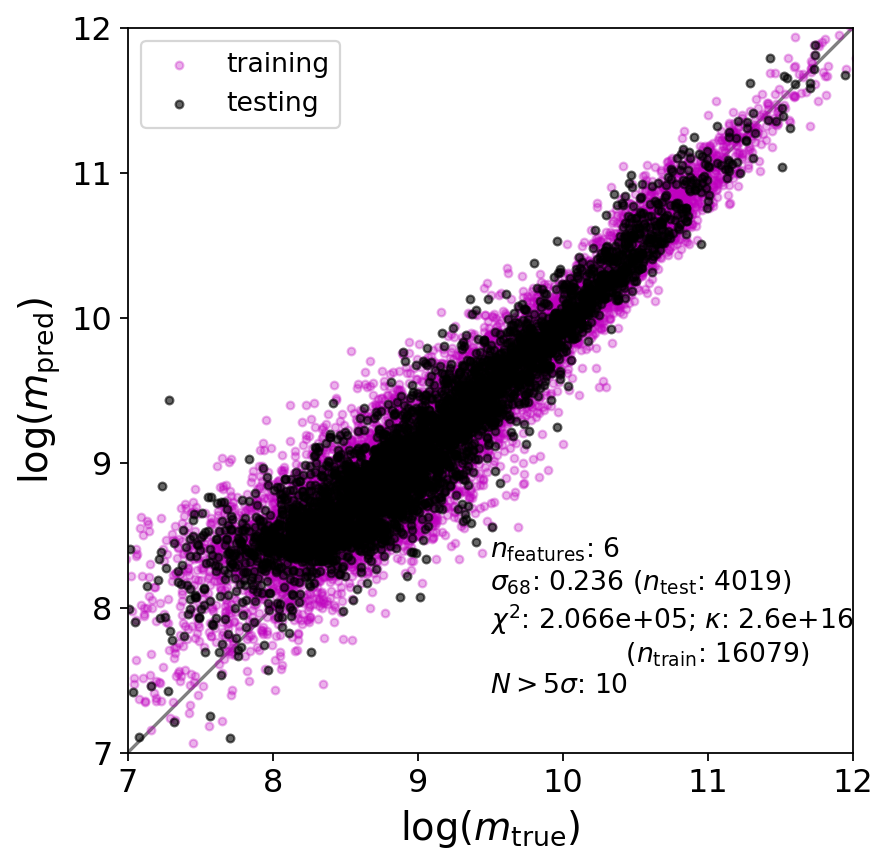

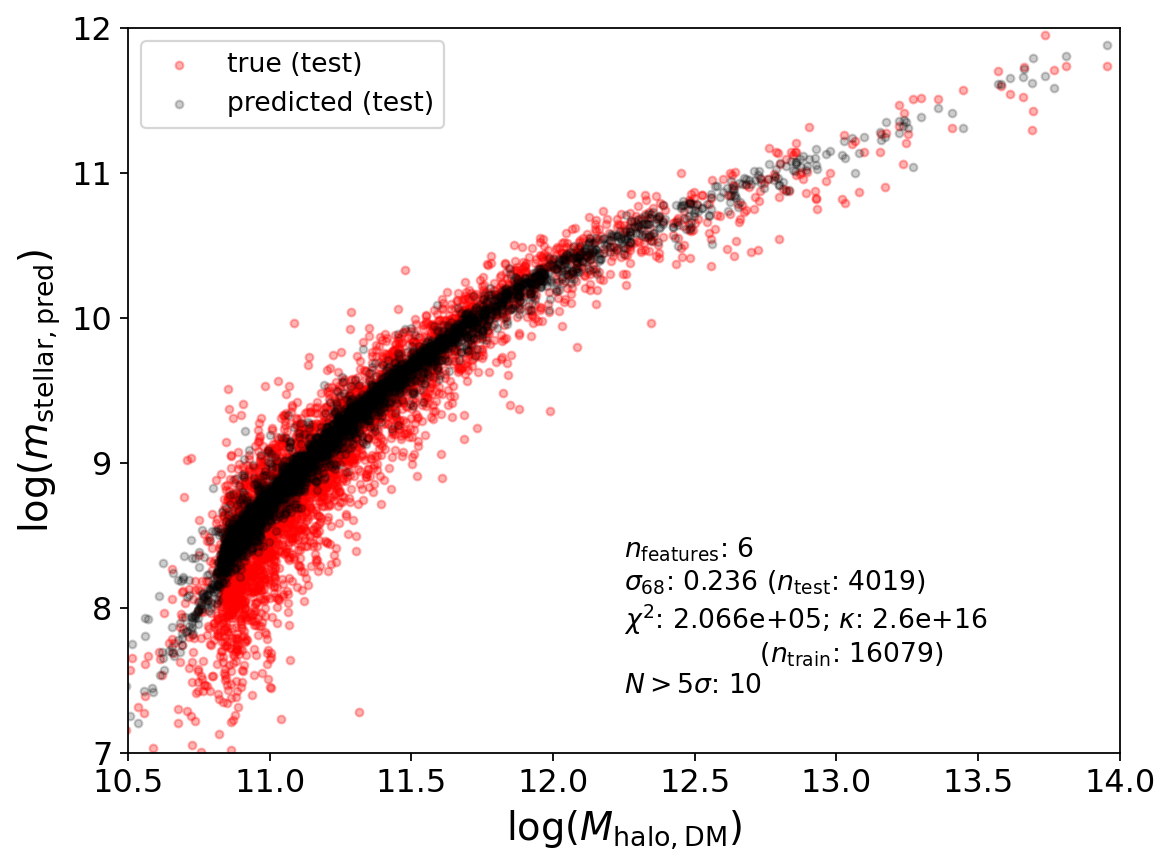

In [152]:
ones_features = np.atleast_2d(np.ones(len(log_m_stellar))).T
fitter = LinearFitter(ones_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m, log_mass_shift=log_mass_shift)
error_powerlawMXV, _ = utils.compute_error(fitter, test_error_type='percentile')
print(error_powerlawMXV)

### Load in full scalar featurizer

In [136]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
for name in names:
    print(name)

g_000
g_001
g_002
e3(g_020)
e2(g_020)
e1(g_020)
e2(g_021)
e3(g_021)
e1(g_021)
e3(g_022)
e2(g_022)
e1(g_022)
e1(g_110)
e2(g_110)
e3(g_110)
e3(g_111)
e2(g_111)
e1(g_111)
e1(g_112)
e2(g_112)
e3(g_112)
e1(g_200)
e3(g_200)
e2(g_200)
e2(g_201)
e3(g_201)
e1(g_201)
e1(g_202)
e2(g_202)
e3(g_202)
g_000 g_000
g_000 g_001
g_000 g_002
g_001 g_001
g_001 g_002
g_002 g_002
[g_010]_j [g_010]_j
e1(g_020) g_000
e2(g_020) g_000
e3(g_020) g_000
e2(g_021) g_000
e1(g_020) g_001
e3(g_021) g_000
[g_010]_j [g_011]_j
e1(g_021) g_000
e2(g_020) g_001
e3(g_020) g_001
[g_010]_j [g_012]_j
e1(g_022) g_000
e2(g_022) g_000
e3(g_022) g_000
e2(g_020) g_002
e3(g_020) g_002
e1(g_020) g_002
e2(g_021) g_001
e3(g_021) g_001
e1(g_021) g_001
[g_011]_j [g_011]_j
e1(g_021) g_002
e1(g_022) g_001
e2(g_022) g_001
e3(g_022) g_001
[g_011]_j [g_012]_j
e3(g_021) g_002
e2(g_021) g_002
[g_012]_j [g_012]_j
e1(g_022) g_002
e2(g_022) g_002
e3(g_022) g_002
e1(g_020) e1(g_020)
e3(g_020) e3(g_020)
e1(g_020) e3(g_020)
e2(g_020) e3(g_020)
[g_020]_

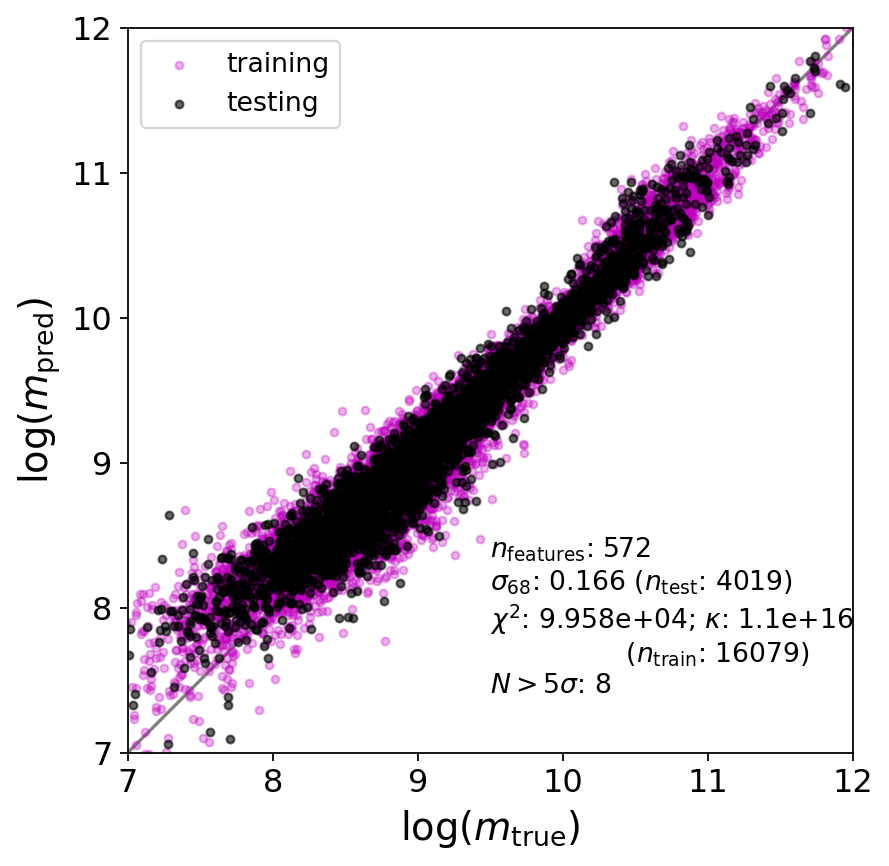

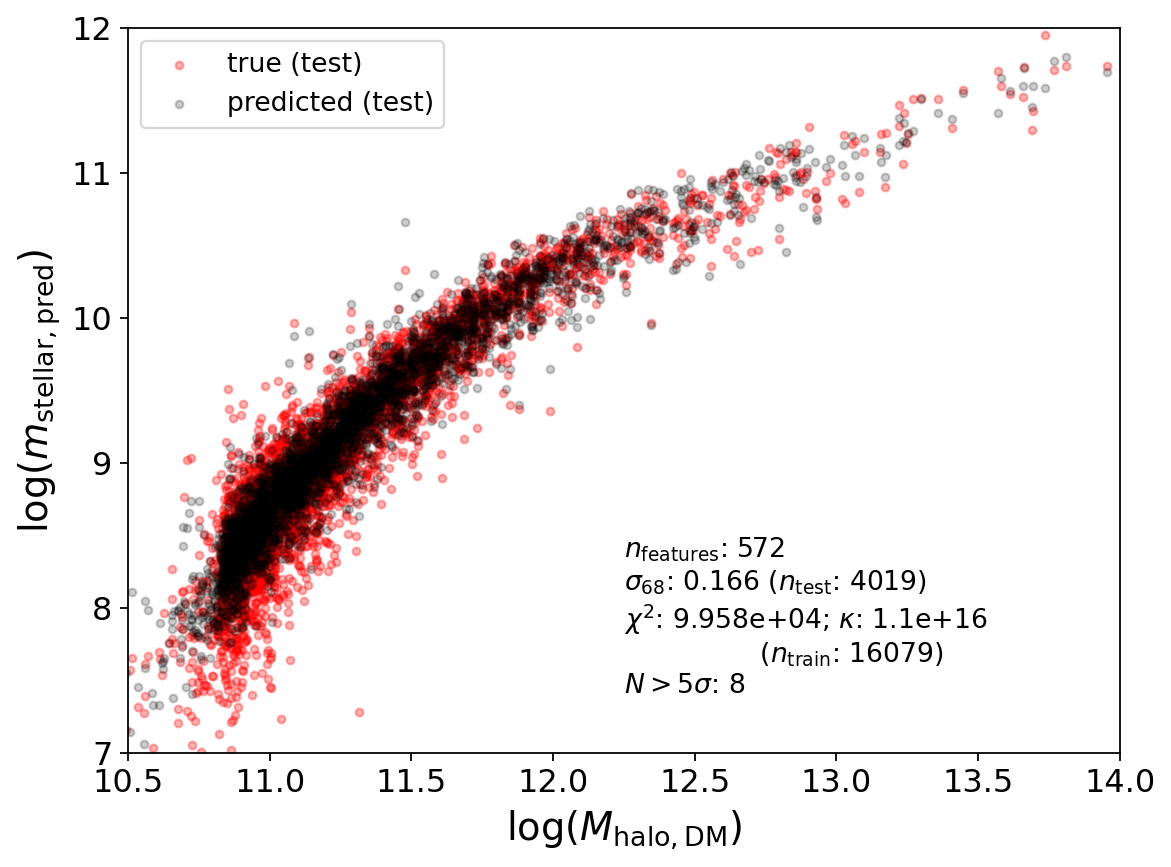

In [154]:
fitter = LinearFitter(scalar_featurizer.scalar_features, log_m_stellar, 
                    y_val_current_powerlaw_fit, uncertainties=uncertainties_genel2019,
                    x_features_extra=x_features_extra)
fitter.split_train_test()
fitter.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter.predict_test()
plotter.plot_fits(fitter, log_m_200m)

In [155]:
chi2_all = fitter.chi2
error_all, n_outliers_all = utils.compute_error(fitter, test_error_type='percentile')
print(error_all)

0.16638179680850973


In [173]:
top_n = 30
features_all = scalar_featurizer.scalar_features
feature_imp_results = feature_importance.get_importance_order_addonein(
            features_all, log_m_stellar, y_val_current_powerlaw_fit, top_n=top_n,
            uncertainties=uncertainties_genel2019, x_features_extra=x_features_extra)

#0 most important
#1 most important
#2 most important
#3 most important
#4 most important
#5 most important
#6 most important
#7 most important
#8 most important
#9 most important
#10 most important
#11 most important
#12 most important
#13 most important
#14 most important
#15 most important
#16 most important
#17 most important
#18 most important
#19 most important
#20 most important
#21 most important
#22 most important
#23 most important
#24 most important
#25 most important
#26 most important
#27 most important
#28 most important
#29 most important


In [174]:
idxs_ordered_best, errors_best, chi2s_best, groups = feature_imp_results

In [175]:
feature_arr_all = scalar_featurizer.scalar_feature_arr
feature_names = [s.name for s in feature_arr_all[0]]
for idx in idxs_ordered_best:
    print(feature_names[idx])

g_001
e1(g_020) e1(g_200)
e2(g_200) e3(g_020)
[A(g_110)]_jk [A(g_110)]_jk
e3(g_021) e3(g_021)
e1(g_022) g_002
e2(g_200) g_002
e1(g_110) e3(g_112)
e2(g_200) e3(g_021)
e2(g_202) e3(g_112)
e1(g_110) e3(g_110)
e2(g_111) e3(g_200)
e1(g_110) e2(g_022)
[g_021]_jk [g_022]_jk
e2(g_112) e2(g_112)
e1(g_111) e1(g_111)
e1(g_021) e3(g_201)
e3(g_202)
e1(g_021) e1(g_202)
e1(g_112) e2(g_111)
[g_101]_j [g_102]_j
e1(g_110) e2(g_110)
e1(g_202) e3(g_021)
e2(g_202) e3(g_200)
[A(g_111)]_jk [A(g_111)]_jk
g_000 g_002
e2(g_021) e2(g_200)
e3(g_202) g_001
e1(g_111) e1(g_201)
e2(g_111) e2(g_111)


25


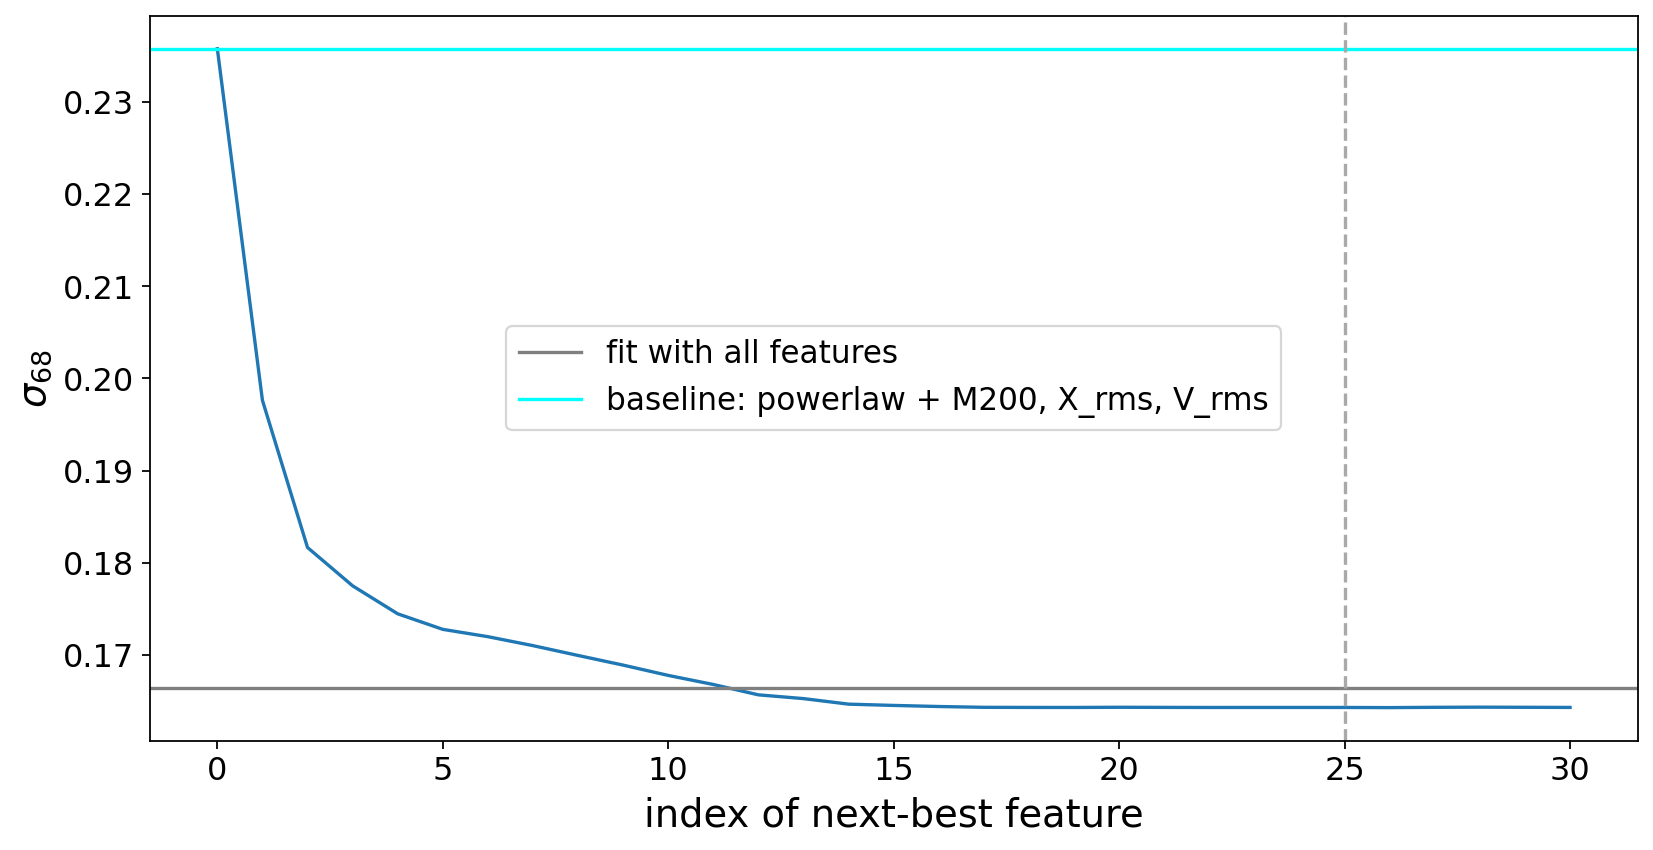

In [177]:
plt.figure(figsize=(12,6))
errors_best_withfirst = [error_powerlawMXV] + errors_best
plt.plot(errors_best_withfirst)
plt.axhline(error_all, color='grey', label='fit with all features')
#plt.axhline(error_powerlaw, color='magenta', label='fit with all')
plt.axhline(error_powerlawMXV, color='cyan', label='baseline: powerlaw + M200, X_rms, V_rms')

n_min = np.argmin(errors_best)
#plt.axvline(5, color='darkgrey', ls='--')
#plt.axvline(22, color='darkgrey', ls='--')
plt.axvline(n_min, color='darkgrey', ls='--')
print(n_min)
plt.xlabel('index of next-best feature')
plt.ylabel(r'$\sigma_{68}$')

plt.legend(fontsize=14)

## Visualize halos

In [160]:
nrows = 2
ncols = 3
n_plot = nrows * ncols

In [161]:
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [162]:
i_best = 0
idx_feat = idxs_ordered_best[i_best]
name_feat = feature_arr_all[0][idx_feat].to_string()
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

16357 52816
7597 10331
15689 48432
846 696
7302 9065
4626 4722


In [164]:
i_best = 1
idx_feat = idxs_ordered_best[i_best]
name_feat = feature_arr_all[0][idx_feat].to_string()
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

15689 48432
8765 13271
847 719
9495 9502
15897 17500
13196 15127


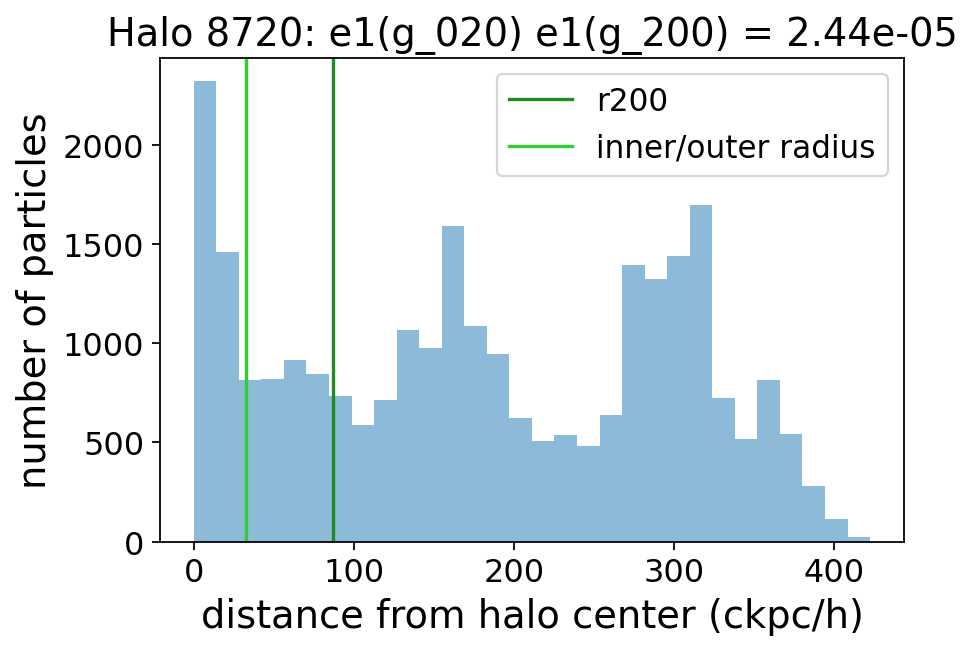

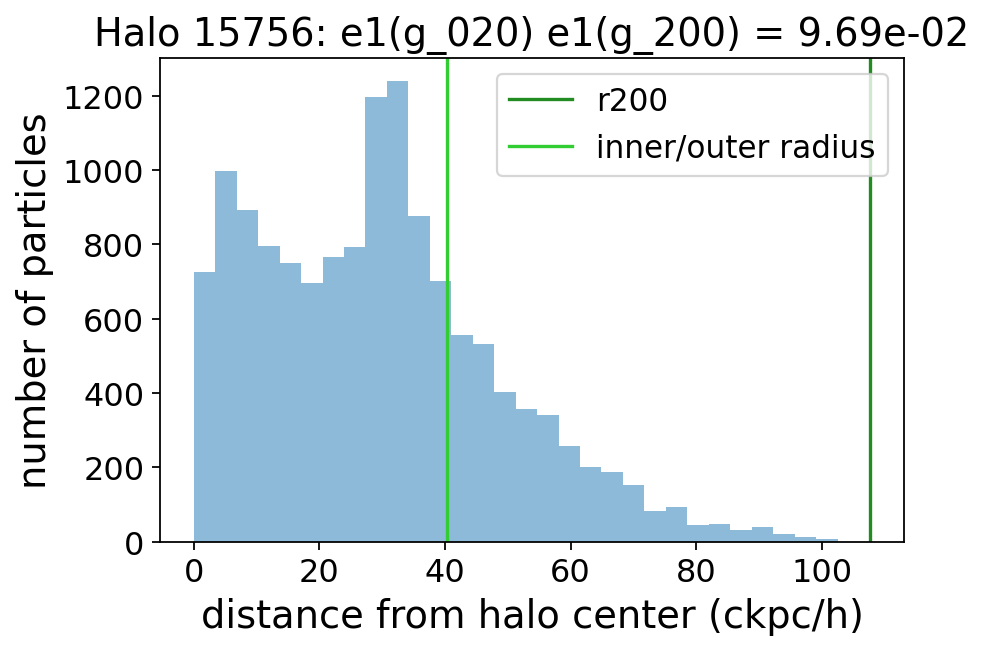

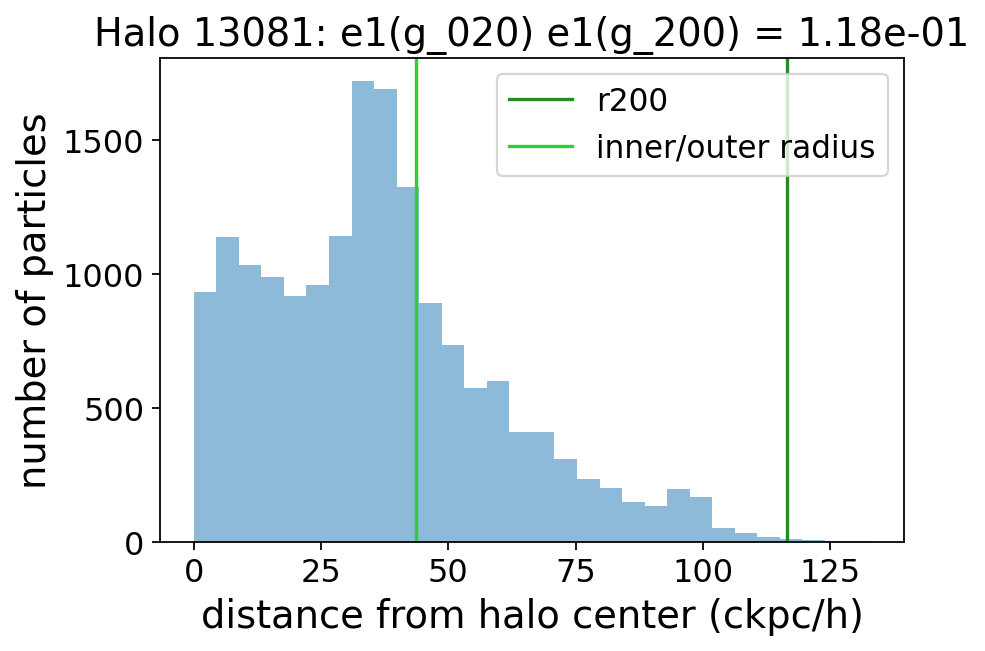

In [172]:
for i, halo in enumerate(halos):
    x_halo_dm_centerzero, _ = halo.load_positions_and_velocities(shift=True, center='x_minPE')
    dists_from_center = np.linalg.norm(x_halo_dm_centerzero, axis=1)
    r200 = halo.catalog_properties['r200m']
    idx_halo = idxs_halos[i]

    plt.figure()
    plt.title(f'Halo {idx_halo}: {feature_names[idx_feat]} = {features_all[idx_halo, idx_feat]:.2e}'
             )
    plt.hist(dists_from_center, bins=30, alpha=0.5)
    plt.axvline(r200, color='forestgreen', label='r200')
    plt.axvline(3/8*r200, color='limegreen', label='inner/outer radius')
    plt.legend(fontsize=14)
    plt.xlabel('distance from halo center (ckpc/h)')
    plt.ylabel('number of particles')

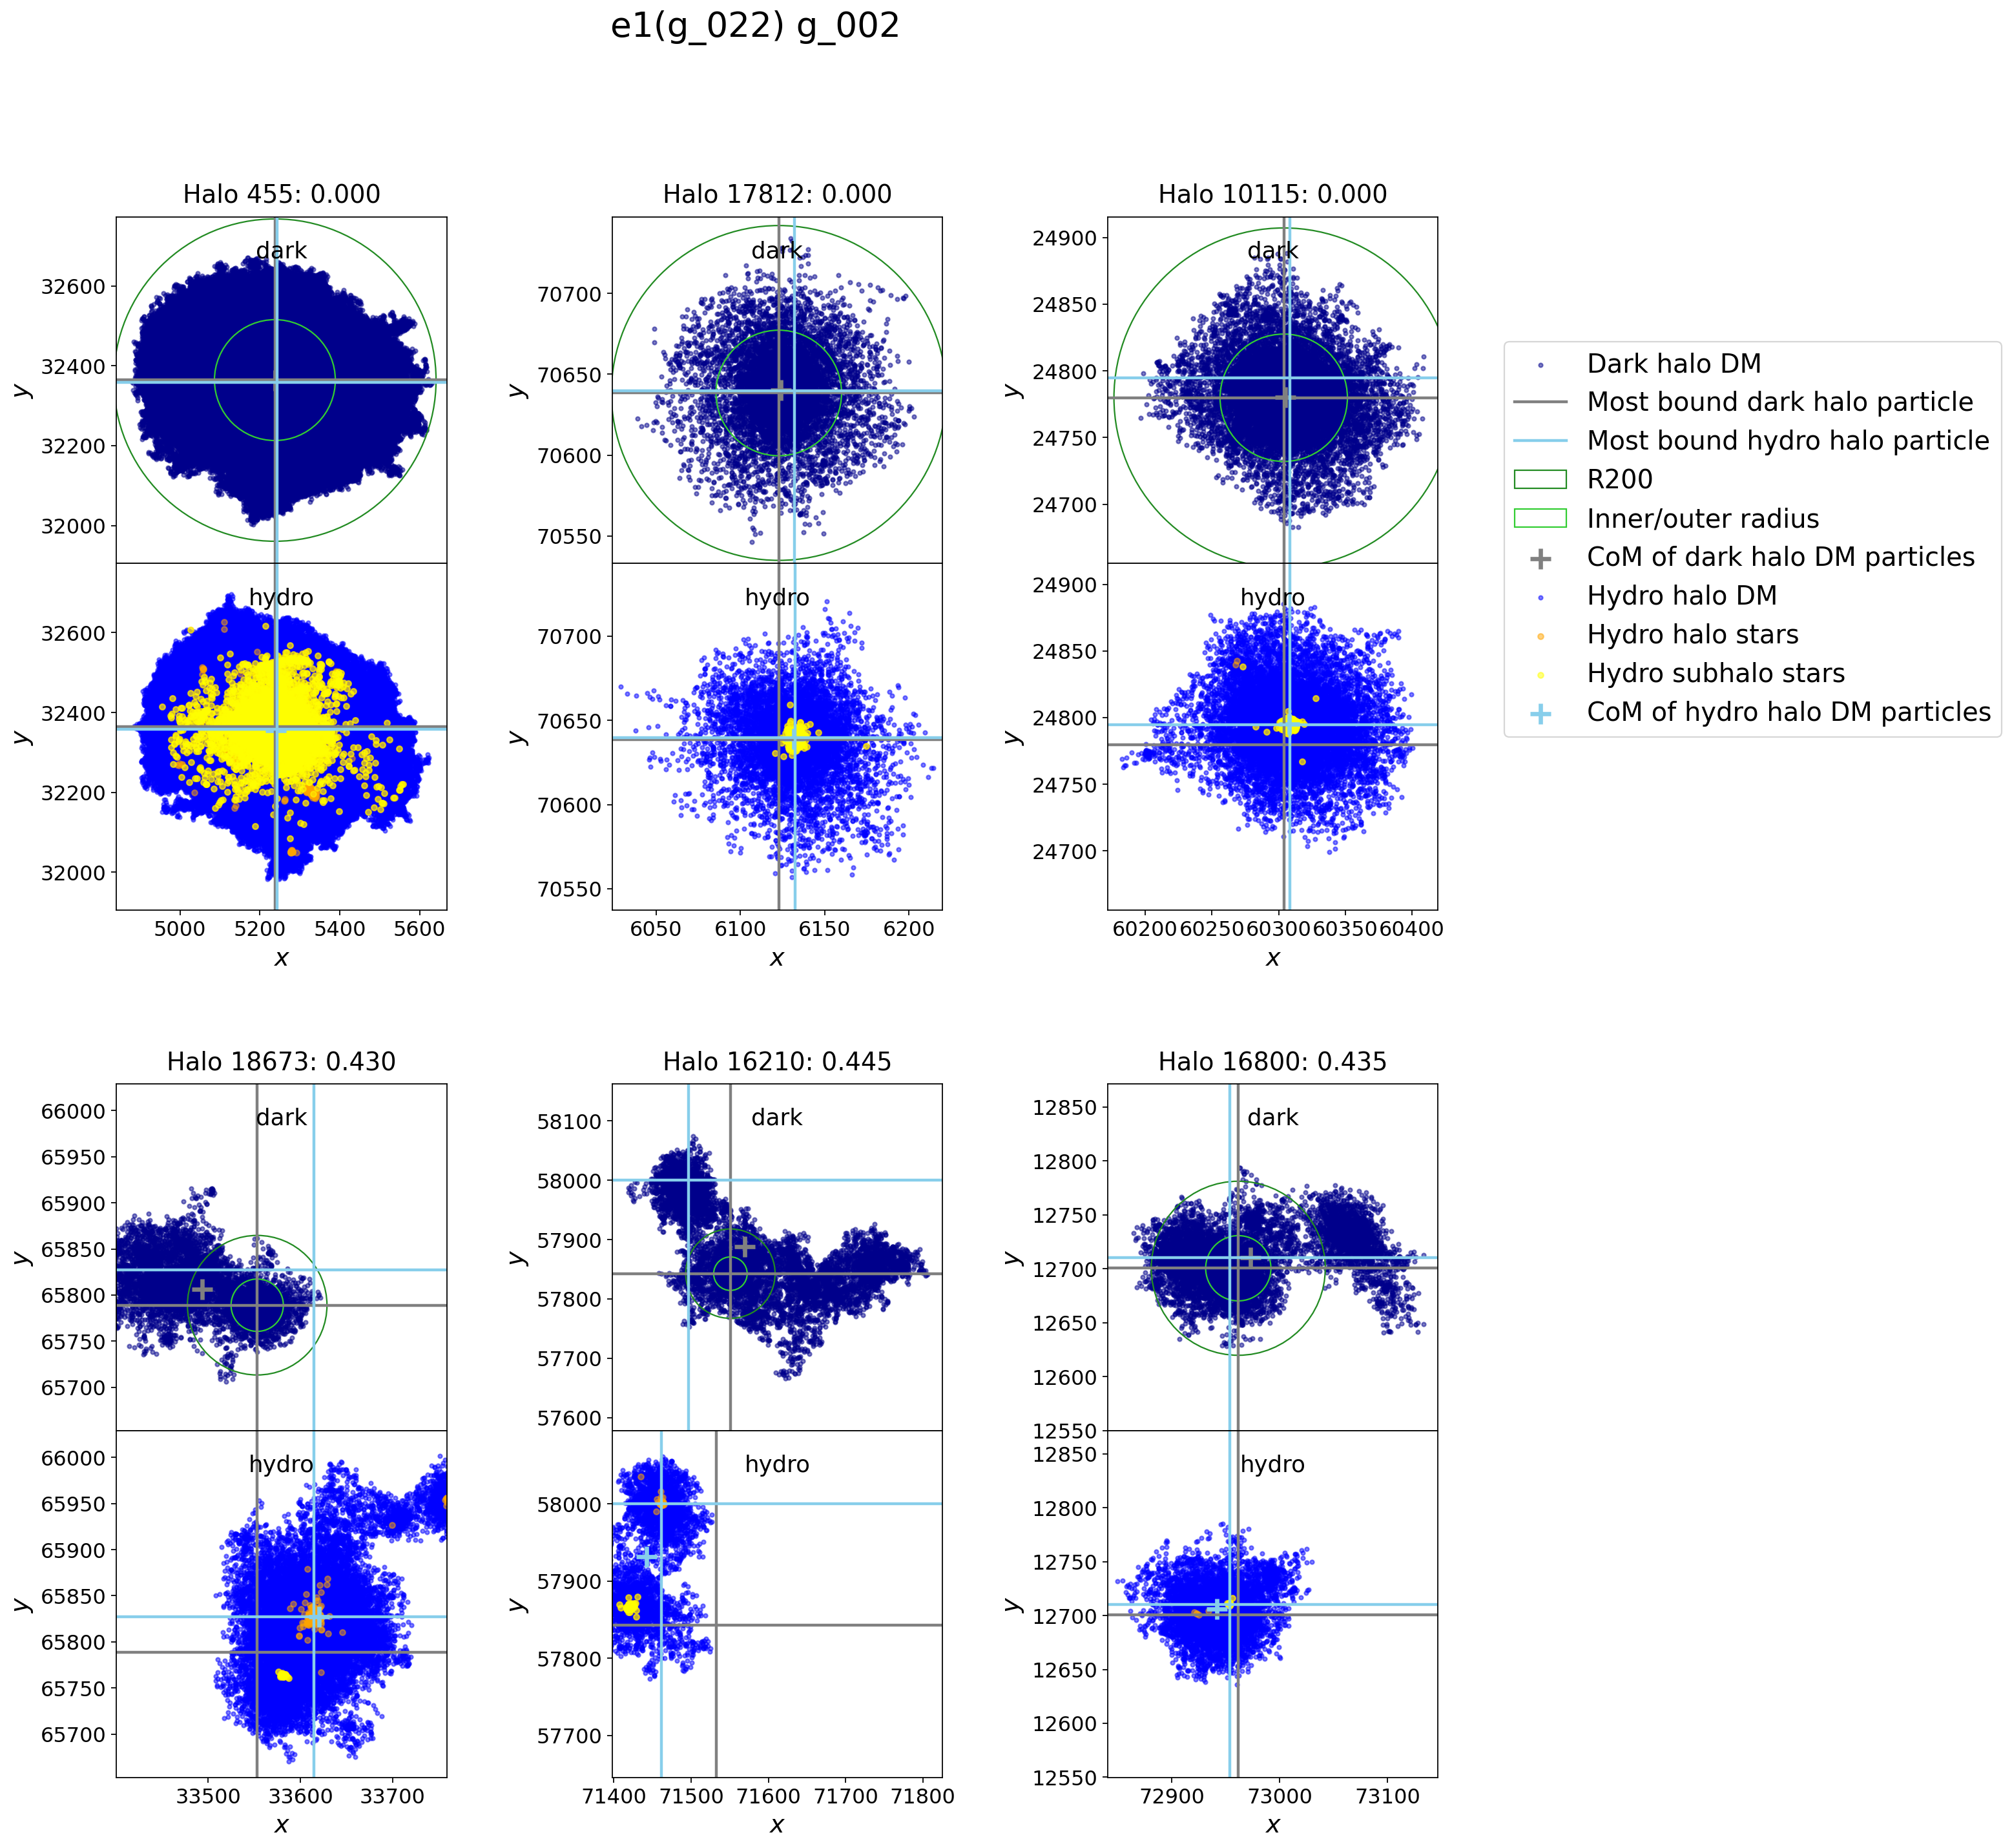

In [178]:
i_best = 5
idx_feat = idxs_ordered_best[i_best]
name_feat = feature_arr_all[0][idx_feat].to_string()
n_each = int(n_plot/2)
idxs_halos_low = np.argpartition(features_all[:,idx_feat], n_each)[:n_each]
idxs_halos_high = np.argpartition(features_all[:,idx_feat], -n_each)[-n_each:]
idxs_halos = np.concatenate((idxs_halos_low, idxs_halos_high))
halos = sim_reader.dark_halo_arr[idxs_halos]
titles = [f'Halo {idx_halo}: {features_all[idx_halo, idx_feat]:.3f}' for idx_halo in idxs_halos]
plotter.plot_halos_dark_and_hydro(halos, sim_reader.base_path_dark, sim_reader.base_path_hydro, sim_reader.snap_num,
                             nrows, ncols, titles, title=name_feat)

# Feature name check

In [18]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
# sim_name = 'TNG100-1'
# sim_name_dark = 'TNG100-1-Dark'
sim_name = 'TNG50-4'
sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin1_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [19]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPE_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG50-4/geometric_features_nstarpartmin1_twin_xminPE_rall.npy


In [20]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [27]:
from IPython.display import display, Markdown

feats_halo = geo_featurizer.geo_feature_arr[0]
for i in range(len(feats_halo)):
    display(Markdown(f"${feats_halo[i].name}$"))

$g_{000}$

$g_{001}$

$g_{002}$

$g_{003}$

$g_{004}$

$g_{005}$

$g_{006}$

$g_{007}$

$g_{008}$

$g_{009}$

$g_{00(10)}$

$g_{010}$

$g_{011}$

$g_{012}$

$g_{013}$

$g_{014}$

$g_{015}$

$g_{016}$

$g_{017}$

$g_{018}$

$g_{019}$

$g_{01(10)}$

$g_{020}$

$g_{021}$

$g_{022}$

$g_{023}$

$g_{024}$

$g_{025}$

$g_{026}$

$g_{027}$

$g_{028}$

$g_{029}$

$g_{02(10)}$

$g_{100}$

$g_{101}$

$g_{102}$

$g_{103}$

$g_{104}$

$g_{105}$

$g_{106}$

$g_{107}$

$g_{108}$

$g_{109}$

$g_{10(10)}$

$g_{110}$

$g_{111}$

$g_{112}$

$g_{113}$

$g_{114}$

$g_{115}$

$g_{116}$

$g_{117}$

$g_{118}$

$g_{119}$

$g_{11(10)}$

$g_{200}$

$g_{201}$

$g_{202}$

$g_{203}$

$g_{204}$

$g_{205}$

$g_{206}$

$g_{207}$

$g_{208}$

$g_{209}$

$g_{20(10)}$

In [24]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)

In [25]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_rebinned)
scalar_featurizer.compute_MXV_from_features()
scalar_featurizer.rescale_geometric_features(scalar_featurizer.M_tot, 
                                             scalar_featurizer.X_rms, 
                                             scalar_featurizer.V_rms)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((scalar_featurizer.M_tot, 
                              scalar_featurizer.X_rms,
                              scalar_featurizer.V_rms)).T
x_features_extra = np.log10(x_features_extra)   

In [26]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

scalar_featurizer.load_features(fn_scalar_features)
names = [f.name for f in scalar_featurizer.scalar_feature_arr[0]]
for name in names:
    display(Markdown(f'${name}$'))

$g_{000}$

$g_{001}$

$g_{002}$

$\lambda_3(g_{020})$

$\lambda_2(g_{020})$

$\lambda_1(g_{020})$

$\lambda_2(g_{021})$

$\lambda_3(g_{021})$

$\lambda_1(g_{021})$

$\lambda_3(g_{022})$

$\lambda_2(g_{022})$

$\lambda_1(g_{022})$

$\lambda_1(g_{110})$

$\lambda_2(g_{110})$

$\lambda_3(g_{110})$

$\lambda_3(g_{111})$

$\lambda_2(g_{111})$

$\lambda_1(g_{111})$

$\lambda_1(g_{112})$

$\lambda_2(g_{112})$

$\lambda_3(g_{112})$

$\lambda_1(g_{200})$

$\lambda_3(g_{200})$

$\lambda_2(g_{200})$

$\lambda_2(g_{201})$

$\lambda_3(g_{201})$

$\lambda_1(g_{201})$

$\lambda_1(g_{202})$

$\lambda_2(g_{202})$

$\lambda_3(g_{202})$

$g_{000} g_{000}$

$g_{000} g_{001}$

$g_{000} g_{002}$

$g_{001} g_{001}$

$g_{001} g_{002}$

$g_{002} g_{002}$

$[g_{010}]_j \, [g_{010}]_j$

$\lambda_1(g_{020}) g_{000}$

$\lambda_2(g_{020}) g_{000}$

$\lambda_3(g_{020}) g_{000}$

$\lambda_2(g_{021}) g_{000}$

$\lambda_1(g_{020}) g_{001}$

$\lambda_3(g_{021}) g_{000}$

$[g_{010}]_j \, [g_{011}]_j$

$\lambda_1(g_{021}) g_{000}$

$\lambda_2(g_{020}) g_{001}$

$\lambda_3(g_{020}) g_{001}$

$[g_{010}]_j \, [g_{012}]_j$

$\lambda_1(g_{022}) g_{000}$

$\lambda_2(g_{022}) g_{000}$

$\lambda_3(g_{022}) g_{000}$

$\lambda_2(g_{020}) g_{002}$

$\lambda_3(g_{020}) g_{002}$

$\lambda_1(g_{020}) g_{002}$

$\lambda_2(g_{021}) g_{001}$

$\lambda_3(g_{021}) g_{001}$

$\lambda_1(g_{021}) g_{001}$

$[g_{011}]_j \, [g_{011}]_j$

$\lambda_1(g_{021}) g_{002}$

$\lambda_1(g_{022}) g_{001}$

$\lambda_2(g_{022}) g_{001}$

$\lambda_3(g_{022}) g_{001}$

$[g_{011}]_j \, [g_{012}]_j$

$\lambda_3(g_{021}) g_{002}$

$\lambda_2(g_{021}) g_{002}$

$[g_{012}]_j \, [g_{012}]_j$

$\lambda_1(g_{022}) g_{002}$

$\lambda_2(g_{022}) g_{002}$

$\lambda_3(g_{022}) g_{002}$

$\lambda_1(g_{020}) \lambda_1(g_{020})$

$\lambda_3(g_{020}) \lambda_3(g_{020})$

$\lambda_1(g_{020}) \lambda_3(g_{020})$

$\lambda_2(g_{020}) \lambda_3(g_{020})$

$[g_{020}]_{jk} \, [g_{020}]_{jk}$

$\lambda_1(g_{020}) \lambda_2(g_{020})$

$\lambda_2(g_{020}) \lambda_2(g_{020})$

$\lambda_1(g_{020}) \lambda_3(g_{021})$

$\lambda_1(g_{021}) \lambda_2(g_{020})$

$\lambda_2(g_{020}) \lambda_2(g_{021})$

$\lambda_2(g_{020}) \lambda_3(g_{021})$

$\lambda_1(g_{021}) \lambda_3(g_{020})$

$\lambda_3(g_{020}) \lambda_3(g_{021})$

$[g_{020}]_{jk} \, [g_{021}]_{jk}$

$\lambda_1(g_{020}) \lambda_2(g_{021})$

$\lambda_1(g_{020}) \lambda_1(g_{021})$

$\lambda_2(g_{021}) \lambda_3(g_{020})$

$\lambda_1(g_{020}) \lambda_2(g_{022})$

$\lambda_1(g_{020}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_2(g_{020})$

$\lambda_2(g_{020}) \lambda_2(g_{022})$

$\lambda_2(g_{020}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_3(g_{020})$

$\lambda_2(g_{022}) \lambda_3(g_{020})$

$\lambda_3(g_{020}) \lambda_3(g_{022})$

$[g_{020}]_{jk} \, [g_{022}]_{jk}$

$\lambda_1(g_{020}) \lambda_1(g_{022})$

$[g_{021}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{021}) \lambda_3(g_{021})$

$\lambda_1(g_{021}) \lambda_3(g_{021})$

$\lambda_3(g_{021}) \lambda_3(g_{021})$

$\lambda_2(g_{021}) \lambda_2(g_{021})$

$\lambda_1(g_{021}) \lambda_1(g_{021})$

$\lambda_1(g_{021}) \lambda_2(g_{021})$

$\lambda_1(g_{021}) \lambda_1(g_{022})$

$\lambda_2(g_{021}) \lambda_2(g_{022})$

$\lambda_1(g_{021}) \lambda_2(g_{022})$

$\lambda_1(g_{021}) \lambda_3(g_{022})$

$[g_{021}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{021}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_2(g_{021})$

$\lambda_2(g_{022}) \lambda_3(g_{021})$

$\lambda_3(g_{021}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_3(g_{021})$

$\lambda_1(g_{022}) \lambda_2(g_{022})$

$\lambda_1(g_{022}) \lambda_1(g_{022})$

$\lambda_3(g_{022}) \lambda_3(g_{022})$

$\lambda_2(g_{022}) \lambda_2(g_{022})$

$[g_{022}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{022}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_3(g_{022})$

$\lambda_2(g_{110}) g_{000}$

$[g_{010}]_j \, [g_{100}]_j$

$\lambda_1(g_{110}) g_{000}$

$\lambda_3(g_{110}) g_{000}$

$\lambda_1(g_{111}) g_{000}$

$\lambda_2(g_{111}) g_{000}$

$\lambda_3(g_{111}) g_{000}$

$\lambda_1(g_{110}) g_{001}$

$\lambda_2(g_{110}) g_{001}$

$\lambda_3(g_{110}) g_{001}$

$[g_{010}]_j \, [g_{101}]_j$

$[g_{100}]_j \, [g_{011}]_j$

$\lambda_1(g_{112}) g_{000}$

$\lambda_2(g_{112}) g_{000}$

$\lambda_1(g_{110}) g_{002}$

$\lambda_2(g_{110}) g_{002}$

$\lambda_3(g_{110}) g_{002}$

$[g_{010}]_j \, [g_{102}]_j$

$\lambda_3(g_{112}) g_{000}$

$[g_{100}]_j \, [g_{012}]_j$

$[g_{011}]_j \, [g_{101}]_j$

$\lambda_1(g_{111}) g_{001}$

$\lambda_3(g_{111}) g_{001}$

$\lambda_2(g_{111}) g_{001}$

$[g_{011}]_j \, [g_{102}]_j$

$\lambda_3(g_{112}) g_{001}$

$\lambda_2(g_{112}) g_{001}$

$[g_{101}]_j \, [g_{012}]_j$

$\lambda_3(g_{111}) g_{002}$

$\lambda_1(g_{112}) g_{001}$

$\lambda_2(g_{111}) g_{002}$

$\lambda_1(g_{111}) g_{002}$

$\lambda_2(g_{112}) g_{002}$

$\lambda_3(g_{112}) g_{002}$

$[g_{012}]_j \, [g_{102}]_j$

$\lambda_1(g_{112}) g_{002}$

$\lambda_1(g_{110}) \lambda_2(g_{020})$

$\lambda_2(g_{020}) \lambda_2(g_{110})$

$\lambda_2(g_{020}) \lambda_3(g_{110})$

$\lambda_1(g_{110}) \lambda_3(g_{020})$

$\lambda_2(g_{110}) \lambda_3(g_{020})$

$\lambda_1(g_{020}) \lambda_2(g_{110})$

$\lambda_3(g_{020}) \lambda_3(g_{110})$

$\lambda_1(g_{020}) \lambda_3(g_{110})$

$[g_{020}]_{jk} \, [g_{110}]_{jk}$

$\lambda_1(g_{020}) \lambda_1(g_{110})$

$[g_{110}]_{jk} \, [g_{021}]_{jk}$

$[g_{020}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{021}) \lambda_3(g_{110})$

$\lambda_1(g_{021}) \lambda_3(g_{110})$

$\lambda_2(g_{110}) \lambda_3(g_{021})$

$\lambda_2(g_{021}) \lambda_2(g_{110})$

$\lambda_1(g_{021}) \lambda_2(g_{110})$

$\lambda_1(g_{110}) \lambda_2(g_{021})$

$\lambda_1(g_{021}) \lambda_1(g_{110})$

$\lambda_3(g_{021}) \lambda_3(g_{110})$

$\lambda_1(g_{110}) \lambda_3(g_{021})$

$\lambda_3(g_{020}) \lambda_3(g_{111})$

$\lambda_2(g_{111}) \lambda_3(g_{020})$

$\lambda_1(g_{111}) \lambda_3(g_{020})$

$\lambda_2(g_{020}) \lambda_3(g_{111})$

$\lambda_2(g_{020}) \lambda_2(g_{111})$

$\lambda_1(g_{111}) \lambda_2(g_{020})$

$\lambda_1(g_{020}) \lambda_3(g_{111})$

$\lambda_1(g_{020}) \lambda_2(g_{111})$

$\lambda_1(g_{020}) \lambda_1(g_{111})$

$\lambda_1(g_{020}) \lambda_1(g_{112})$

$\lambda_1(g_{020}) \lambda_2(g_{112})$

$\lambda_1(g_{020}) \lambda_3(g_{112})$

$\lambda_3(g_{020}) \lambda_3(g_{112})$

$\lambda_2(g_{020}) \lambda_2(g_{112})$

$\lambda_2(g_{020}) \lambda_3(g_{112})$

$[g_{020}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{112}) \lambda_2(g_{020})$

$\lambda_1(g_{112}) \lambda_3(g_{020})$

$\lambda_2(g_{112}) \lambda_3(g_{020})$

$\lambda_1(g_{110}) \lambda_2(g_{022})$

$[g_{110}]_{jk} \, [g_{022}]_{jk}$

$\lambda_3(g_{022}) \lambda_3(g_{110})$

$\lambda_2(g_{022}) \lambda_3(g_{110})$

$\lambda_1(g_{022}) \lambda_3(g_{110})$

$\lambda_2(g_{110}) \lambda_3(g_{022})$

$\lambda_2(g_{022}) \lambda_2(g_{110})$

$\lambda_1(g_{022}) \lambda_2(g_{110})$

$\lambda_1(g_{110}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_1(g_{110})$

$[g_{021}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{111}) \lambda_3(g_{021})$

$\lambda_1(g_{111}) \lambda_3(g_{021})$

$\lambda_2(g_{021}) \lambda_3(g_{111})$

$\lambda_2(g_{021}) \lambda_2(g_{111})$

$\lambda_1(g_{111}) \lambda_2(g_{021})$

$\lambda_1(g_{021}) \lambda_3(g_{111})$

$\lambda_1(g_{021}) \lambda_2(g_{111})$

$\lambda_3(g_{021}) \lambda_3(g_{111})$

$\lambda_1(g_{021}) \lambda_1(g_{111})$

$\lambda_1(g_{111}) \lambda_2(g_{022})$

$\lambda_3(g_{021}) \lambda_3(g_{112})$

$\lambda_1(g_{022}) \lambda_1(g_{111})$

$\lambda_1(g_{111}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_2(g_{111})$

$\lambda_2(g_{022}) \lambda_2(g_{111})$

$[g_{021}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{022}) \lambda_3(g_{111})$

$\lambda_2(g_{022}) \lambda_3(g_{111})$

$\lambda_3(g_{022}) \lambda_3(g_{111})$

$\lambda_2(g_{111}) \lambda_3(g_{022})$

$\lambda_1(g_{021}) \lambda_1(g_{112})$

$\lambda_1(g_{021}) \lambda_2(g_{112})$

$\lambda_1(g_{021}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_2(g_{021})$

$\lambda_2(g_{021}) \lambda_2(g_{112})$

$\lambda_2(g_{021}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_3(g_{021})$

$\lambda_2(g_{112}) \lambda_3(g_{021})$

$[g_{111}]_{jk} \, [g_{022}]_{jk}$

$\lambda_2(g_{112}) \lambda_3(g_{022})$

$\lambda_1(g_{112}) \lambda_3(g_{022})$

$\lambda_2(g_{022}) \lambda_3(g_{112})$

$\lambda_1(g_{022}) \lambda_1(g_{112})$

$\lambda_1(g_{112}) \lambda_2(g_{022})$

$\lambda_1(g_{022}) \lambda_3(g_{112})$

$\lambda_1(g_{022}) \lambda_2(g_{112})$

$\lambda_2(g_{022}) \lambda_2(g_{112})$

$[g_{022}]_{jk} \, [g_{112}]_{jk}$

$\lambda_3(g_{022}) \lambda_3(g_{112})$

$\lambda_3(g_{200}) g_{000}$

$\lambda_2(g_{200}) g_{000}$

$\lambda_1(g_{200}) g_{000}$

$[g_{100}]_j \, [g_{100}]_j$

$\lambda_2(g_{200}) g_{001}$

$\lambda_3(g_{201}) g_{000}$

$\lambda_2(g_{201}) g_{000}$

$\lambda_1(g_{201}) g_{000}$

$[g_{100}]_j \, [g_{101}]_j$

$\lambda_3(g_{200}) g_{001}$

$\lambda_1(g_{200}) g_{001}$

$\lambda_3(g_{200}) g_{002}$

$\lambda_1(g_{200}) g_{002}$

$\lambda_2(g_{200}) g_{002}$

$[g_{100}]_j \, [g_{102}]_j$

$\lambda_1(g_{202}) g_{000}$

$\lambda_2(g_{202}) g_{000}$

$\lambda_3(g_{202}) g_{000}$

$[g_{101}]_j \, [g_{101}]_j$

$\lambda_1(g_{201}) g_{001}$

$\lambda_2(g_{201}) g_{001}$

$\lambda_3(g_{201}) g_{001}$

$[g_{101}]_j \, [g_{102}]_j$

$\lambda_3(g_{202}) g_{001}$

$\lambda_3(g_{201}) g_{002}$

$\lambda_2(g_{201}) g_{002}$

$\lambda_1(g_{201}) g_{002}$

$\lambda_2(g_{202}) g_{001}$

$\lambda_1(g_{202}) g_{001}$

$\lambda_1(g_{202}) g_{002}$

$\lambda_3(g_{202}) g_{002}$

$[g_{102}]_j \, [g_{102}]_j$

$\lambda_2(g_{202}) g_{002}$

$\lambda_2(g_{200}) \lambda_3(g_{020})$

$\lambda_1(g_{110}) \lambda_1(g_{110})$

$\lambda_2(g_{110}) \lambda_2(g_{110})$

$\lambda_1(g_{110}) \lambda_2(g_{110})$

$\lambda_3(g_{110}) \lambda_3(g_{110})$

$\lambda_1(g_{110}) \lambda_3(g_{110})$

$\lambda_2(g_{110}) \lambda_3(g_{110})$

$[g_{110}]_{jk} \, [g_{110}]_{jk}$

$[g_{110}^A]_{jk} \, [g_{110}^A]_{jk}$

$\lambda_3(g_{020}) \lambda_3(g_{200})$

$\lambda_1(g_{020}) \lambda_3(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{020})$

$\lambda_2(g_{020}) \lambda_3(g_{200})$

$\lambda_2(g_{020}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_2(g_{020})$

$[g_{020}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{020}) \lambda_2(g_{200})$

$\lambda_1(g_{020}) \lambda_1(g_{200})$

$\lambda_1(g_{111}) \lambda_2(g_{110})$

$\lambda_2(g_{110}) \lambda_2(g_{111})$

$\lambda_2(g_{110}) \lambda_3(g_{111})$

$\lambda_1(g_{111}) \lambda_3(g_{110})$

$\lambda_2(g_{111}) \lambda_3(g_{110})$

$\lambda_1(g_{020}) \lambda_2(g_{201})$

$\lambda_3(g_{110}) \lambda_3(g_{111})$

$\lambda_1(g_{020}) \lambda_3(g_{201})$

$\lambda_1(g_{110}) \lambda_1(g_{111})$

$\lambda_1(g_{201}) \lambda_2(g_{020})$

$\lambda_2(g_{020}) \lambda_2(g_{201})$

$[g_{110}]_{jk} \, [g_{111}]_{jk}$

$\lambda_1(g_{110}) \lambda_3(g_{111})$

$[g_{110}^A]_{jk} \, [g_{111}^A]_{jk}$

$\lambda_1(g_{110}) \lambda_2(g_{111})$

$\lambda_3(g_{021}) \lambda_3(g_{200})$

$[g_{020}]_{jk} \, [g_{201}]_{jk}$

$[g_{200}]_{jk} \, [g_{021}]_{jk}$

$\lambda_2(g_{021}) \lambda_3(g_{200})$

$\lambda_1(g_{021}) \lambda_3(g_{200})$

$\lambda_2(g_{200}) \lambda_3(g_{021})$

$\lambda_2(g_{021}) \lambda_2(g_{200})$

$\lambda_1(g_{021}) \lambda_2(g_{200})$

$\lambda_2(g_{020}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{020})$

$\lambda_2(g_{201}) \lambda_3(g_{020})$

$\lambda_3(g_{020}) \lambda_3(g_{201})$

$\lambda_1(g_{020}) \lambda_1(g_{201})$

$\lambda_1(g_{021}) \lambda_1(g_{200})$

$\lambda_1(g_{200}) \lambda_2(g_{021})$

$\lambda_1(g_{200}) \lambda_3(g_{021})$

$[g_{110}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{020}) \lambda_1(g_{202})$

$\lambda_2(g_{020}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_3(g_{020})$

$\lambda_2(g_{202}) \lambda_3(g_{020})$

$\lambda_3(g_{020}) \lambda_3(g_{202})$

$[g_{020}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{020}) \lambda_2(g_{202})$

$\lambda_2(g_{020}) \lambda_2(g_{202})$

$[g_{110}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{110}) \lambda_3(g_{112})$

$\lambda_2(g_{112}) \lambda_3(g_{110})$

$[g_{200}]_{jk} \, [g_{022}]_{jk}$

$\lambda_3(g_{022}) \lambda_3(g_{200})$

$\lambda_2(g_{022}) \lambda_3(g_{200})$

$\lambda_1(g_{022}) \lambda_3(g_{200})$

$\lambda_2(g_{200}) \lambda_3(g_{022})$

$\lambda_2(g_{022}) \lambda_2(g_{200})$

$\lambda_1(g_{022}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{022})$

$\lambda_1(g_{200}) \lambda_2(g_{022})$

$\lambda_1(g_{022}) \lambda_1(g_{200})$

$\lambda_3(g_{110}) \lambda_3(g_{112})$

$\lambda_1(g_{110}) \lambda_1(g_{112})$

$\lambda_1(g_{110}) \lambda_2(g_{112})$

$\lambda_1(g_{110}) \lambda_3(g_{112})$

$\lambda_1(g_{020}) \lambda_3(g_{202})$

$\lambda_1(g_{112}) \lambda_2(g_{110})$

$\lambda_2(g_{110}) \lambda_2(g_{112})$

$\lambda_1(g_{112}) \lambda_3(g_{110})$

$\lambda_1(g_{202}) \lambda_2(g_{020})$

$\lambda_1(g_{021}) \lambda_1(g_{201})$

$[g_{111}^A]_{jk} \, [g_{111}^A]_{jk}$

$[g_{111}]_{jk} \, [g_{111}]_{jk}$

$\lambda_2(g_{111}) \lambda_3(g_{111})$

$\lambda_1(g_{111}) \lambda_3(g_{111})$

$\lambda_1(g_{021}) \lambda_2(g_{201})$

$\lambda_1(g_{021}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{021})$

$\lambda_2(g_{021}) \lambda_2(g_{201})$

$\lambda_2(g_{021}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{021})$

$\lambda_2(g_{201}) \lambda_3(g_{021})$

$\lambda_3(g_{021}) \lambda_3(g_{201})$

$[g_{021}]_{jk} \, [g_{201}]_{jk}$

$\lambda_3(g_{111}) \lambda_3(g_{111})$

$\lambda_1(g_{111}) \lambda_2(g_{111})$

$\lambda_2(g_{111}) \lambda_2(g_{111})$

$\lambda_1(g_{111}) \lambda_1(g_{111})$

$\lambda_2(g_{202}) \lambda_3(g_{021})$

$\lambda_3(g_{021}) \lambda_3(g_{202})$

$[g_{021}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \lambda_3(g_{021})$

$\lambda_2(g_{021}) \lambda_3(g_{202})$

$\lambda_2(g_{021}) \lambda_2(g_{202})$

$\lambda_2(g_{111}) \lambda_2(g_{112})$

$\lambda_1(g_{021}) \lambda_3(g_{202})$

$\lambda_1(g_{021}) \lambda_2(g_{202})$

$\lambda_1(g_{021}) \lambda_1(g_{202})$

$\lambda_1(g_{111}) \lambda_1(g_{112})$

$\lambda_1(g_{201}) \lambda_2(g_{022})$

$\lambda_1(g_{022}) \lambda_1(g_{201})$

$\lambda_1(g_{202}) \lambda_2(g_{021})$

$\lambda_1(g_{111}) \lambda_2(g_{112})$

$\lambda_1(g_{022}) \lambda_2(g_{201})$

$\lambda_2(g_{111}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_2(g_{111})$

$\lambda_1(g_{112}) \lambda_3(g_{111})$

$\lambda_2(g_{112}) \lambda_3(g_{111})$

$\lambda_3(g_{111}) \lambda_3(g_{112})$

$\lambda_1(g_{201}) \lambda_3(g_{022})$

$[g_{111}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_1(g_{111}) \lambda_3(g_{112})$

$[g_{201}]_{jk} \, [g_{022}]_{jk}$

$[g_{111}]_{jk} \, [g_{112}]_{jk}$

$\lambda_2(g_{022}) \lambda_3(g_{201})$

$\lambda_1(g_{022}) \lambda_3(g_{201})$

$\lambda_2(g_{201}) \lambda_3(g_{022})$

$\lambda_2(g_{022}) \lambda_2(g_{201})$

$\lambda_3(g_{022}) \lambda_3(g_{201})$

$\lambda_1(g_{112}) \lambda_1(g_{112})$

$[g_{022}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{022}) \lambda_3(g_{202})$

$\lambda_1(g_{022}) \lambda_2(g_{202})$

$\lambda_2(g_{022}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_3(g_{022})$

$\lambda_2(g_{202}) \lambda_3(g_{022})$

$\lambda_1(g_{022}) \lambda_1(g_{202})$

$\lambda_2(g_{112}) \lambda_3(g_{112})$

$[g_{112}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{112}) \lambda_3(g_{112})$

$\lambda_1(g_{022}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_2(g_{022})$

$\lambda_2(g_{022}) \lambda_2(g_{202})$

$\lambda_3(g_{112}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_2(g_{112})$

$[g_{112}^A]_{jk} \, [g_{112}^A]_{jk}$

$\lambda_2(g_{112}) \lambda_2(g_{112})$

$[g_{110}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{110}) \lambda_3(g_{200})$

$\lambda_1(g_{110}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_2(g_{110})$

$\lambda_2(g_{110}) \lambda_2(g_{200})$

$\lambda_2(g_{110}) \lambda_3(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{110})$

$\lambda_2(g_{200}) \lambda_3(g_{110})$

$\lambda_3(g_{110}) \lambda_3(g_{200})$

$\lambda_1(g_{110}) \lambda_1(g_{200})$

$\lambda_1(g_{110}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{110})$

$\lambda_2(g_{110}) \lambda_2(g_{201})$

$\lambda_2(g_{111}) \lambda_2(g_{200})$

$\lambda_1(g_{111}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{111})$

$\lambda_1(g_{200}) \lambda_2(g_{111})$

$\lambda_1(g_{111}) \lambda_1(g_{200})$

$\lambda_1(g_{201}) \lambda_2(g_{110})$

$\lambda_2(g_{110}) \lambda_3(g_{201})$

$\lambda_3(g_{110}) \lambda_3(g_{201})$

$\lambda_2(g_{201}) \lambda_3(g_{110})$

$\lambda_2(g_{200}) \lambda_3(g_{111})$

$\lambda_1(g_{111}) \lambda_3(g_{200})$

$\lambda_2(g_{111}) \lambda_3(g_{200})$

$\lambda_3(g_{111}) \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{111}]_{jk}$

$\lambda_1(g_{110}) \lambda_2(g_{201})$

$\lambda_1(g_{110}) \lambda_1(g_{201})$

$[g_{110}]_{jk} \, [g_{201}]_{jk}$

$\lambda_2(g_{200}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{112})$

$\lambda_1(g_{112}) \lambda_3(g_{200})$

$\lambda_2(g_{112}) \lambda_2(g_{200})$

$\lambda_3(g_{112}) \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{112}]_{jk}$

$\lambda_1(g_{200}) \lambda_2(g_{112})$

$\lambda_2(g_{110}) \lambda_3(g_{202})$

$\lambda_1(g_{110}) \lambda_1(g_{202})$

$\lambda_1(g_{110}) \lambda_2(g_{202})$

$\lambda_1(g_{110}) \lambda_3(g_{202})$

$\lambda_2(g_{112}) \lambda_3(g_{200})$

$\lambda_1(g_{112}) \lambda_1(g_{200})$

$\lambda_1(g_{202}) \lambda_2(g_{110})$

$\lambda_2(g_{202}) \lambda_3(g_{110})$

$\lambda_3(g_{110}) \lambda_3(g_{202})$

$[g_{110}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{110}) \lambda_2(g_{202})$

$\lambda_1(g_{202}) \lambda_3(g_{110})$

$\lambda_1(g_{111}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{111})$

$\lambda_2(g_{111}) \lambda_2(g_{201})$

$\lambda_2(g_{111}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{111})$

$\lambda_2(g_{201}) \lambda_3(g_{111})$

$\lambda_3(g_{111}) \lambda_3(g_{201})$

$[g_{111}]_{jk} \, [g_{201}]_{jk}$

$\lambda_1(g_{111}) \lambda_1(g_{201})$

$\lambda_1(g_{111}) \lambda_2(g_{201})$

$\lambda_1(g_{112}) \lambda_3(g_{201})$

$\lambda_1(g_{111}) \lambda_1(g_{202})$

$\lambda_1(g_{111}) \lambda_2(g_{202})$

$\lambda_1(g_{111}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_2(g_{111})$

$\lambda_2(g_{111}) \lambda_2(g_{202})$

$[g_{201}]_{jk} \, [g_{112}]_{jk}$

$[g_{111}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{112}) \lambda_3(g_{201})$

$\lambda_2(g_{202}) \lambda_3(g_{111})$

$\lambda_1(g_{202}) \lambda_3(g_{111})$

$\lambda_2(g_{111}) \lambda_3(g_{202})$

$\lambda_3(g_{111}) \lambda_3(g_{202})$

$\lambda_1(g_{201}) \lambda_3(g_{112})$

$\lambda_2(g_{201}) \lambda_3(g_{112})$

$\lambda_3(g_{112}) \lambda_3(g_{201})$

$\lambda_2(g_{112}) \lambda_2(g_{201})$

$\lambda_1(g_{112}) \lambda_2(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{112})$

$\lambda_1(g_{112}) \lambda_1(g_{201})$

$\lambda_1(g_{112}) \lambda_2(g_{202})$

$\lambda_1(g_{112}) \lambda_1(g_{202})$

$\lambda_3(g_{112}) \lambda_3(g_{202})$

$\lambda_2(g_{202}) \lambda_3(g_{112})$

$\lambda_1(g_{202}) \lambda_3(g_{112})$

$\lambda_2(g_{112}) \lambda_3(g_{202})$

$\lambda_2(g_{112}) \lambda_2(g_{202})$

$\lambda_1(g_{112}) \lambda_3(g_{202})$

$[g_{112}]_{jk} \, [g_{202}]_{jk}$

$\lambda_1(g_{202}) \lambda_2(g_{112})$

$\lambda_1(g_{200}) \lambda_1(g_{200})$

$\lambda_2(g_{200}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_2(g_{200})$

$\lambda_3(g_{200}) \lambda_3(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{200})$

$\lambda_2(g_{200}) \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{200}]_{jk}$

$\lambda_1(g_{201}) \lambda_3(g_{200})$

$[g_{200}]_{jk} \, [g_{201}]_{jk}$

$\lambda_3(g_{200}) \lambda_3(g_{201})$

$\lambda_2(g_{201}) \lambda_3(g_{200})$

$\lambda_2(g_{200}) \lambda_3(g_{201})$

$\lambda_2(g_{200}) \lambda_2(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{201})$

$\lambda_1(g_{200}) \lambda_2(g_{201})$

$\lambda_1(g_{200}) \lambda_1(g_{201})$

$\lambda_2(g_{200}) \lambda_3(g_{202})$

$\lambda_2(g_{202}) \lambda_3(g_{200})$

$\lambda_1(g_{202}) \lambda_3(g_{200})$

$\lambda_2(g_{200}) \lambda_2(g_{202})$

$\lambda_1(g_{202}) \lambda_2(g_{200})$

$\lambda_1(g_{200}) \lambda_3(g_{202})$

$\lambda_1(g_{200}) \lambda_2(g_{202})$

$[g_{200}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{200}) \lambda_3(g_{202})$

$\lambda_1(g_{200}) \lambda_1(g_{202})$

$[g_{201}]_{jk} \, [g_{201}]_{jk}$

$\lambda_2(g_{201}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{201})$

$\lambda_2(g_{201}) \lambda_2(g_{201})$

$\lambda_1(g_{201}) \lambda_1(g_{201})$

$\lambda_3(g_{201}) \lambda_3(g_{201})$

$\lambda_1(g_{201}) \lambda_2(g_{202})$

$[g_{201}]_{jk} \, [g_{202}]_{jk}$

$\lambda_3(g_{201}) \lambda_3(g_{202})$

$\lambda_2(g_{202}) \lambda_3(g_{201})$

$\lambda_1(g_{202}) \lambda_3(g_{201})$

$\lambda_2(g_{201}) \lambda_3(g_{202})$

$\lambda_2(g_{201}) \lambda_2(g_{202})$

$\lambda_1(g_{202}) \lambda_2(g_{201})$

$\lambda_1(g_{201}) \lambda_3(g_{202})$

$\lambda_1(g_{201}) \lambda_1(g_{202})$

$\lambda_2(g_{202}) \lambda_2(g_{202})$

$[g_{202}]_{jk} \, [g_{202}]_{jk}$

$\lambda_2(g_{202}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_3(g_{202})$

$\lambda_3(g_{202}) \lambda_3(g_{202})$

$\lambda_1(g_{202}) \lambda_2(g_{202})$

$\lambda_1(g_{202}) \lambda_1(g_{202})$